# M3 – Week 1

### Towards an image classification pipeline

This work was made by Edward Hogea, Alex Carrillo and Guillem Martínez

### Imports

In [50]:
import os
import cv2
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
import optuna
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from typing import List, Dict, Tuple, Any
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model._base import BaseEstimator
from copy import deepcopy
import pandas as pd

### Data Loader

In [3]:
def preprocess_paths(filepaths: List[str]):
    """
    Removes the "../" (first three characters) using a list comprehension
    """
    return [fpath[3:] for fpath in filepaths]


def load_image(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load image at path.
    """
    return cv2.imread(path)


def load_images(files: List[str], desc: str, n_process: int = cpu_count()) -> Tuple[np.ndarray]:
    """
    Load a list of images by their full filenames.
    """
    images = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(load_image)(file) for file in tqdm(files, desc=desc))
    print(f"read: {len(images)} images")
    return images


def show_image(image: np.ndarray, title: str = 'image'):
    """Shows image."""
    plt.imshow(image[...,::-1])
    plt.title(title)
    plt.show()

### Read and preprocess data

Let us first read the train and test files

In [4]:
train_images_filenames = pickle.load(open('MIT_split/train_images_filenames.dat',"rb"))
test_images_filenames = pickle.load(open('MIT_split/test_images_filenames.dat',"rb"))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('MIT_split/train_labels.dat',"rb")) 
test_labels = pickle.load(open('MIT_split/test_labels.dat',"rb"))

# We have to get rid of every '../' since we are working from a DeepNote environment
# and the code is within the same folder
train_images_filenames = preprocess_paths(train_images_filenames)
test_images_filenames = preprocess_paths(test_images_filenames)

# Load images
train_images = load_images(files=train_images_filenames, desc='Loading TRAIN images...')
test_images = load_images(files=test_images_filenames, desc='Loading TEST images...')

Loading TRAIN images...: 100%|██████████| 1881/1881 [00:02<00:00, 643.52it/s]


read: 1881 images


Loading TEST images...: 100%|██████████| 807/807 [00:01<00:00, 759.44it/s] 

read: 807 images


### Keypoint detectors and descriptors

In [5]:
def get_detector(name: str = 'sift', n_features: int = 100) -> Any:
    if name == 'kaze':
        detector = cv2.KAZE_create()
    elif name == 'akaze':
        detector = cv2.AKAZE_create(descriptor_size=n_features)
    elif name == 'brisk':
        detector = cv2.BRISK_create()
    elif name == 'sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    elif name == 'dense_sift':
        pass
    else:
        raise ValueError(
            f"Given detector {name} is an invalid one."
        )
    return detector

In [94]:
def compute_image_descriptors(image: np.ndarray, detector: Any) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute descriptors for an image using a feature detector.
    """
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors

def compute_descriptors(images: List[np.ndarray], labels: Tuple, detector: str, n_features: int, desc: str, n_process: int = cpu_count(), verbose: bool = False):
    """
    Compute descriptors for an image using a feature detector.
    Descriptors are filtered (because images without descriptors are not useful)
    and a numpy array with all the descriptors stacked together is built.
    """
    detector = get_detector(detector, n_features)
    features = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(compute_image_descriptors)(img, detector) for img in tqdm(images, desc=desc, position=0, leave=verbose))
    _, descriptors = list(zip(*features))
    filtered_descriptors, filtered_labels = zip(*[(x, y) for x, y in zip(descriptors, labels) if x is not None])
    if verbose:
        print(f"\nprocessed {len(descriptors)} images, {detector.getDefaultName()} descriptors of n_features={n_features}")
        print(f"\n{len(descriptors) - len(filtered_descriptors)} images without keypoints (nor descriptors)")
    return filtered_descriptors, filtered_labels

In [95]:
train_descriptors, filtered_train_labels = compute_descriptors(
    images=train_images,
    labels=train_labels,
    detector='akaze',
    n_features=100,
    desc='Computing descriptors for TRAIN images...',
    verbose=True
)

Computing descriptors for TRAIN images...: 100%|██████████| 1881/1881 [00:12<00:00, 152.36it/s]



processed 1881 images, Feature2D.AKAZE descriptors of n_features=100

10 images without keypoints (nor descriptors)


### BOVW Codebook and Visual Words

In [96]:
def compute_visual_words(descriptors: np.ndarray, desc: str, codebook_size: int = 128, verbose: bool = False) -> np.ndarray:
    # Generate codebook
    D = np.vstack(descriptors)
    codebook = MiniBatchKMeans(n_clusters=codebook_size, verbose=False, batch_size=128 * 20, compute_labels=False,
        reassignment_ratio=10**-4, random_state=42, n_init='auto')
    codebook.fit(D)
    # Compute visual words
    visual_words = np.zeros((len(descriptors), codebook_size), dtype=np.float32)
    not_det = 0
    for i in tqdm(range(len(descriptors)), desc=desc, position=0, leave=verbose):
        if descriptors[i] is None:
            not_det += 1
            visual_words[i,:] = np.zeros(codebook_size, dtype=np.float32)
        else:
            words = codebook.predict(descriptors[i])
            visual_words[i,:] = np.bincount(words, minlength=codebook_size)
    if verbose:
        print(f"\nGenerated {visual_words.shape[0]} histograms with a k={visual_words.shape[1]} vocabulary.")
        print(f'\nNumber of images where keypoints were not detected: {not_det}')
    return visual_words

In [97]:
train_visual_words = compute_visual_words(
    descriptors=train_descriptors,
    codebook_size=128,
    desc="Computing visual words vocabulary with TRAIN descriptors...",
    verbose=True
)

Computing visual words vocabulary with TRAIN descriptors...: 100%|██████████| 1871/1871 [00:01<00:00, 1631.88it/s]


Generated 1871 histograms with a k=128 vocabulary.

Number of images where keypoints were not detected: 0


In [127]:
params = {
    'detector': ['akaze'],
    'n_features': np.arange(100, 400, 100),
    'codebook_size': [128, 256],
    'n_neighbors': [3, 5],
    'metric': ["euclidean", "manhattan"]
}

evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_knn.csv'

results = []
for detector in params['detector']:
    for n_features in params['n_features']:

        train_descriptors, filtered_train_labels = compute_descriptors(
            images=train_images,
            labels=train_labels,
            detector=detector,
            n_features=n_features,
            desc='Computing descriptors for TRAIN images...'
        )
        for codebook_size in params['codebook_size']:
            
            train_visual_words = compute_visual_words(
                descriptors=train_descriptors,
                codebook_size=codebook_size,
                desc="Computing visual words vocabulary with TRAIN descriptors..."
            )
            
            clf = KNeighborsClassifier(n_jobs=-1)
            clf_grid = GridSearchCV(
                estimator=clf,
                param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                cv=8,
                scoring=evaluation_metrics,
                refit="accuracy",
                return_train_score=True)
            clf_grid.fit(train_visual_words, filtered_train_labels)

            idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

            # Params
            n_neighbors = clf_grid.best_params_['n_neighbors']
            distance = clf_grid.best_params_['metric']
            results_data = [detector, n_features, codebook_size, n_neighbors, distance]
            
            # Scores
            for eval_metric in evaluation_metrics:
                train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                results_data.extend([train_score, val_score, std_train_score, std_val_score])

            results.append(results_data)
            print(f"Appended GridSearchCV results for {detector} with {n_features} features and {codebook_size} codebook size.")

columns = ['detector', 'n_features', 'codebook_size', 'n_neighbors', 'distance'] \

for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])

df = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")

Appended GridSearchCV results for akaze with 100 features and 128 codebook size.


Appended GridSearchCV results for akaze with 100 features and 256 codebook size.


Appended GridSearchCV results for akaze with 200 features and 128 codebook size.


Appended GridSearchCV results for akaze with 200 features and 256 codebook size.


Appended GridSearchCV results for akaze with 300 features and 128 codebook size.


Appended GridSearchCV results for akaze with 300 features and 256 codebook size.
Saved results to results/hyper_params_knn.csv


In [128]:
df

,detector,n_features,codebook_size,n_neighbors,distance,train_accuracy,val_accuracy,std_train_accuracy,std_val_accuracy,train_f1_weighted,val_f1_weighted,std_train_f1_weighted,std_val_f1_weighted
0,akaze,100,128,5,euclidean,0.480415,0.290740,0.008954,0.031580,0.467329,0.270026,0.010742,0.030347
1,akaze,100,256,5,euclidean,0.423914,0.248546,0.007434,0.030623,0.418839,0.222448,0.008560,0.035785
2,akaze,200,128,5,euclidean,0.527144,0.320160,0.007536,0.027271,0.523425,0.302420,0.008516,0.028616
3,akaze,200,256,5,euclidean,0.429488,0.260305,0.001280,0.028712,0.419026,0.231138,0.002728,0.036064
4,akaze,300,128,5,euclidean,0.511033,0.328702,0.006058,0.037955,0.504677,0.314436,0.006751,0.038819
5,akaze,300,256,5,euclidean,0.436588,0.264042,0.004018,0.024577,0.429615,0.240715,0.004894,0.028246


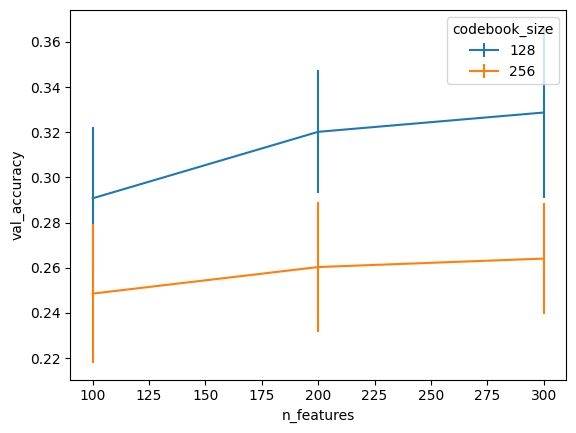

In [137]:
lvls_variable = 'codebook_size'

fig, ax = plt.subplots()
lvls = df[lvls_variable].unique()
for i in lvls:
    ax.errorbar(x=df[df[lvls_variable]==i]['n_features'],
                y=df[df[lvls_variable]==i]['val_accuracy'], 
                yerr=df[df[lvls_variable]==i]['std_val_accuracy'], label=i)
ax.set_xlabel('n_features')
ax.set_ylabel('val_accuracy')
ax.legend(title=lvls_variable)

### Additional functions to use in the TODOs

In [36]:
def get_dimension_reduction(dim_red_name: str = 'pca', n_components: int = 64) -> Any:
    """
    Creates and parametrize a dimensionality reduction method given a config dictionary
    """
    if dim_red_name == 'pca':
        dim_red = PCA(n_components=n_components)
    elif dim_red_name == 'lda':
        dim_red = LinearDiscriminantAnalysis(n_components=n_components)
    else:
        raise ValueError(
            f"\nGiven dimensionality reduction algorithm {dim_red_name} is an invalid one."
        )
    return dim_red

In [26]:
def compute_descriptors_batch_test(images: List[np.ndarray], desc: str, n_process: int = cpu_count(), verbose: bool = False):
    """
    Compute descriptors for an image using a feature detector. Images doesn't need to be filtered
    """
    detector = get_detector("akaze")
    # features = [compute_descriptors(img, detector) for img in tqdm(images, desc=desc, position=0)]
    features = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(compute_descriptors)(img, detector) for img in tqdm(images, desc=desc, position=0))
    _, descriptors = list(zip(*features))
    if verbose:
        print(f"\nprocessed {len(descriptors)} images, {detector.getDefaultName()} descriptors of size k={len(descriptors[0])}")
    return descriptors

In [15]:
def evaluate_vw_predictions(visual_words,test_labels, knn):
    score = knn.score(visual_words, test_labels)
    print(f'\nThe trained model generates results with {100*score} accuracy.')
    return score

In [45]:
def dimensionality_reduction(visual_words, train_labels, visual_words_test, test_labels, dim_red_method, clf):
    vw_reduced = dim_red_method.fit_transform(visual_words, train_labels)
    clf.fit(vw_reduced, train_labels) 
    vw_test_reduced = dim_red_method.transform(visual_words_test)
    return vw_test_reduced

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=960299dc-720f-41b7-96d3-c9358e726808' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>